In [55]:
import time
import operator
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

# End Point & Subscription Key

In [56]:
# Variables
_region = 'westcentralus' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/face/v1.0/detect'.format(_region)
_key = '6ef41877566d45d68b93b527f187fbfa' #Here you enter your subscription key
_maxNumRetries = 10

# HTTP REQUEST

In [87]:
def processRequest( json, data, headers, params ):

    """
    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                    #print(result)
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

# 將結果輸出至原圖

In [88]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 2 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currFaceId = currFace['faceId']
        currAge = currFace['faceAttributes']['age']
        currGender = currFace['faceAttributes']['gender']
        currEmotion = max(currFace['faceAttributes']['emotion'].items(), key=operator.itemgetter(1))[0]
        cv2.putText( img, str(currEmotion), (faceRectangle['left'],faceRectangle['top']-3), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0),1 )
        cv2.putText( img, str(currAge), (faceRectangle['left'],faceRectangle['top']-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0),1 )
        cv2.putText( img, str(currGender), (faceRectangle['left'],faceRectangle['top']-40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0),1)
        print(currFaceId)

# 讀取圖檔URL並呈現

1f35809d-fb06-4a8b-b6ca-f7616a9cd2e2


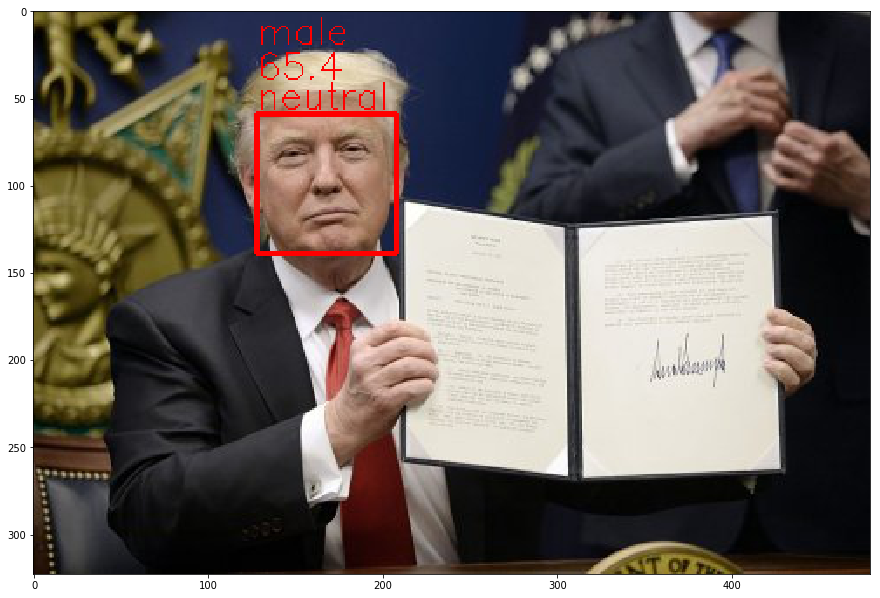

In [91]:
# URL direction to image
urlImage = 'http://static3.businessinsider.com/image/588f4285713ba11c008b5578-480/donald-trump.jpg'
#urlImage = 'https://www.news-medical.net/image.axd?picture=2017%2F9%2Femotions.jpg'
# Computer Vision parameters
params = {'returnFaceAttributes':'age,gender,emotion'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

# 從本地端讀取圖檔

9dcb7600-a38c-44a5-bf59-7fff2f2ffb7d


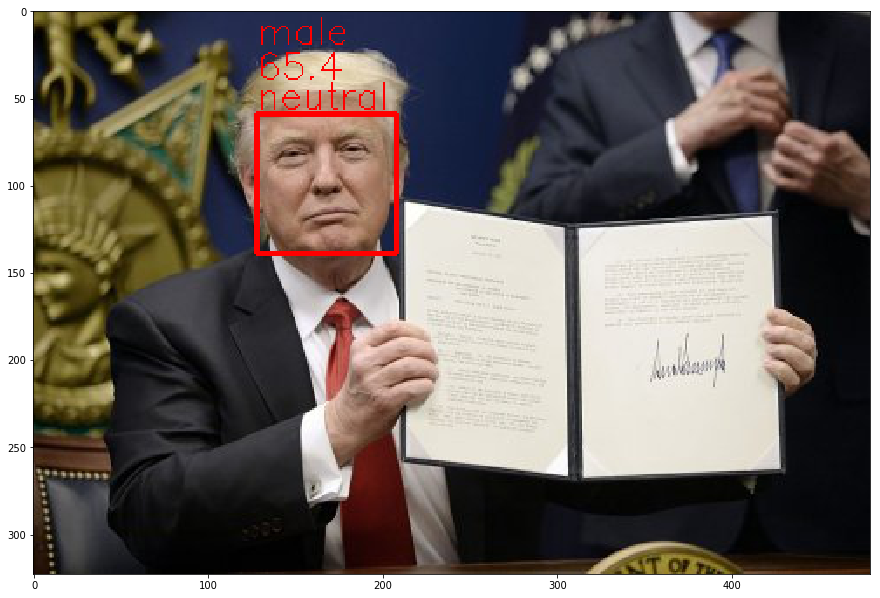

In [92]:
# Load raw image file into memory
pathToFileInDisk = r'/Users/ian/Downloads/donald-trump.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None
params = {'returnFaceAttributes':'age,gender,emotion'} 

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )